In [40]:
import VisionTransformer as vit

import copy
import datetime
import h5py
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.nn.functional as F

from datetime import datetime
from gc import collect
from os import cpu_count
from sklearn.model_selection import train_test_split
from time import sleep
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchinfo import summary
from tqdm import tqdm

In [41]:
random_seed = 1
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
cudnn.benchmark = True

In [42]:
collect()
torch.cuda.empty_cache()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Running on device: {device}")

Running on device: cuda


## Compare CNN and ViT

In [69]:
vit_weights = vit.VisionTransformer(dspl_size=104, patch_size=8, embed_dim=128, depth=12, n_heads=8, mlp_ratio=4.,p=0., attn_p=0.,drop_path=0).double()

In [70]:
vit_weights.load_state_dict(torch.load('logs_and_weights/ViT-2022-Nov-03 09:55:11/ViT-2022-Nov-03 09:55:11_best_val_loss_2e-05.pth')['best_model_weights'], strict=False)

<All keys matched successfully>

In [71]:
cnn_weights = keras.models.load_model('../mltfm/models/model_noise_1e-4.h5')

In [72]:
dspl = h5py.File('data/displacements_25.h5')["data"]
trac = h5py.File('data/tractions_25.h5')["data"]

dspl_ = np.moveaxis(np.array(dspl),3 ,1)
trac_ = np.moveaxis(np.array(trac),3 ,1)

X_test = torch.from_numpy(dspl_).double()
Y_test = torch.from_numpy(trac_).double()

In [75]:
pred_vit = vit_weights(X_test)
pred_cnn = cnn_weights.predict(dspl)

1/1 [==============================] - 0s 60ms/step


In [76]:
loss = torch.nn.MSELoss(reduction='mean')
loss_vit = loss(pred_vit, Y_test)
loss_cnn = loss(torch.tensor(np.moveaxis(pred_cnn, 3, 1)), Y_test)

<IPython.core.display.Javascript object>


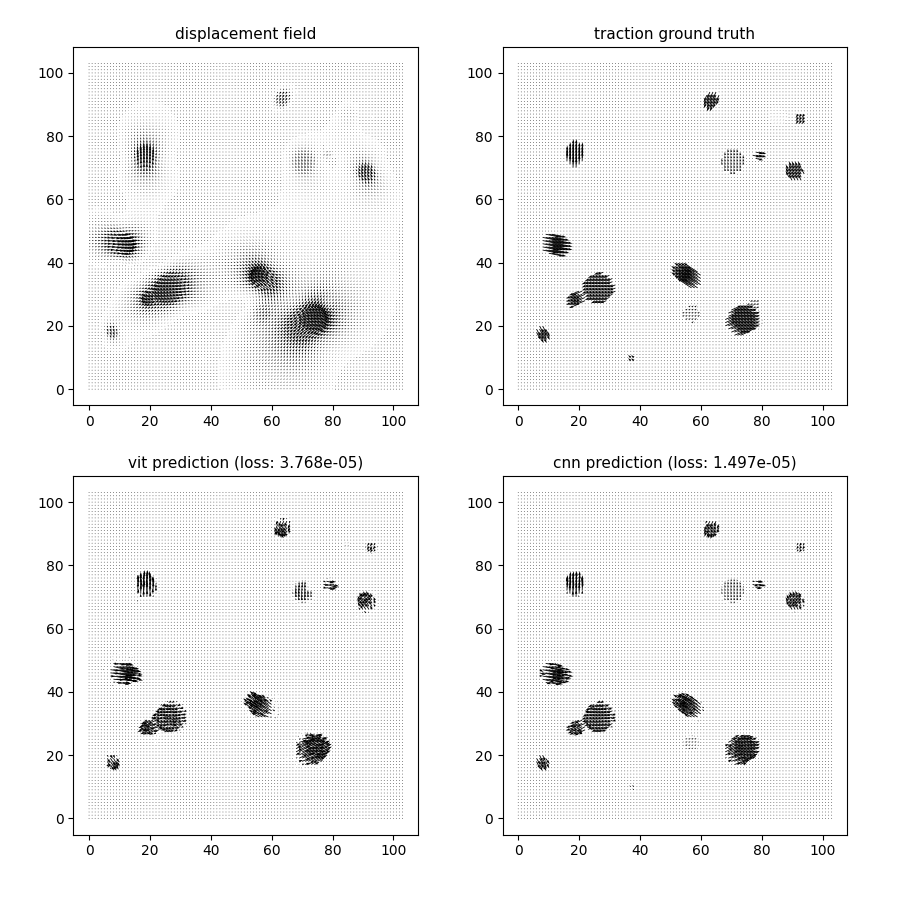

Text(0.5, 1.0, 'cnn prediction (loss: 1.497e-05)')

In [38]:
get_ipython().run_line_magic('matplotlib', 'notebook')

# Plots
fig, axs = plt.subplots(2,2, figsize=(9, 9))
fig.tight_layout(pad=3, w_pad=3, h_pad=3)
axs[0, 0].quiver(dspl[0,:,:,0], dspl[0,:,:,1], scale=1)
axs[0, 0].set_title('displacement field', {'fontsize': 11})

axs[0, 1].quiver(trac[0,:,:,0], trac[0,:,:,1], scale=10)
axs[0, 1].set_title('traction ground truth', {'fontsize': 11})

axs[1, 0].quiver(pred_vit[0,0,:,:].detach().numpy(), pred_vit[0,1,:,:].detach().numpy(), scale=10)
axs[1, 0].set_title(f'vit prediction (loss: {torch.round(loss_vit/5, decimals=8)})', {'fontsize': 11})

axs[1, 1].quiver(pred_cnn[0,:,:,0], pred_cnn[0,:,:,1], scale=10)
axs[1, 1].set_title(f'cnn prediction (loss: {torch.round(loss_cnn/5, decimals=8)})', {'fontsize': 11})